In [4]:
pip install pwlf

  Created wheel for pwlf: filename=pwlf-2.0.4-cp37-none-any.whl size=16156 sha256=0732c8775a020cdb4405d7e6a55d5dcab3bf8f34ad930cdb72b8cab3dae3cd29
  Stored in directory: /root/.cache/pip/wheels/aa/b4/ef/2cb67a24a71a0d9dd93a5ba02f46106e9fa34dd2e3d9d8b4a0
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18184 sha256=ea6e3dcec5cabba7bffcd49f496df5b9495f37d85f00f48f473a639781fca8a2
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pwlf pyDOE


In [10]:
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import time
import numpy as np
import pwlf
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error


drive.mount('/content/drive')


data = pd.read_csv('/content/drive/MyDrive/TS/sales.csv')
data['0'] = pd.to_datetime(data['0'])
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,2013-01-01,13.0,12.0,19.0,10.0,11.0,20.0,7.0,16.0,11.0,14.0,33.0,41.0,43.0,30.0,26.0,27.0,21.0,39.0,31.0,36.0,15.0,19.0,26.0,17.0,14.0,13.0,9.0,21.0,20.0,18.0,10.0,21.0,9.0,13.0,4.0,7.0,6.0,13.0,10.0,9.0,11.0,4.0,13.0,10.0,9.0,4.0,5.0,10.0,9.0,8.0
1,2013-01-02,11.0,16.0,8.0,12.0,9.0,6.0,4.0,10.0,9.0,14.0,43.0,33.0,27.0,28.0,22.0,18.0,23.0,25.0,26.0,34.0,30.0,32.0,16.0,23.0,16.0,14.0,11.0,21.0,22.0,28.0,11.0,14.0,15.0,16.0,5.0,7.0,8.0,10.0,15.0,9.0,6.0,6.0,9.0,5.0,5.0,9.0,8.0,9.0,11.0,13.0
2,2013-01-03,14.0,16.0,10.0,8.0,12.0,11.0,8.0,12.0,20.0,16.0,23.0,46.0,38.0,37.0,26.0,20.0,13.0,34.0,33.0,34.0,14.0,26.0,17.0,27.0,15.0,13.0,14.0,21.0,20.0,26.0,8.0,12.0,9.0,12.0,8.0,17.0,9.0,16.0,7.0,14.0,8.0,12.0,10.0,12.0,3.0,10.0,9.0,14.0,8.0,10.0
3,2013-01-04,13.0,20.0,15.0,15.0,8.0,7.0,7.0,21.0,22.0,17.0,18.0,50.0,35.0,44.0,23.0,24.0,34.0,39.0,42.0,50.0,10.0,34.0,25.0,27.0,15.0,17.0,15.0,19.0,25.0,31.0,19.0,17.0,16.0,19.0,7.0,10.0,2.0,13.0,19.0,16.0,9.0,16.0,20.0,7.0,12.0,5.0,4.0,10.0,15.0,10.0
4,2013-01-05,10.0,16.0,22.0,19.0,13.0,12.0,8.0,15.0,22.0,12.0,34.0,44.0,47.0,36.0,22.0,32.0,25.0,45.0,50.0,42.0,23.0,25.0,34.0,19.0,10.0,21.0,14.0,24.0,25.0,22.0,12.0,14.0,16.0,13.0,7.0,14.0,15.0,18.0,16.0,19.0,8.0,9.0,13.0,5.0,8.0,8.0,9.0,14.0,13.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,14.0,19.0,16.0,15.0,15.0,14.0,13.0,13.0,16.0,19.0,55.0,74.0,61.0,57.0,31.0,41.0,31.0,61.0,46.0,43.0,26.0,36.0,40.0,31.0,21.0,21.0,18.0,28.0,29.0,32.0,16.0,26.0,22.0,25.0,12.0,10.0,6.0,16.0,23.0,16.0,6.0,20.0,17.0,15.0,16.0,9.0,14.0,14.0,18.0,19.0
1822,2017-12-28,19.0,21.0,17.0,26.0,13.0,8.0,18.0,25.0,19.0,12.0,50.0,69.0,59.0,49.0,33.0,43.0,23.0,67.0,67.0,35.0,21.0,40.0,30.0,33.0,26.0,32.0,15.0,36.0,32.0,33.0,20.0,23.0,18.0,24.0,15.0,11.0,10.0,20.0,20.0,29.0,15.0,18.0,21.0,23.0,10.0,14.0,5.0,19.0,18.0,14.0
1823,2017-12-29,15.0,18.0,21.0,28.0,18.0,16.0,18.0,34.0,16.0,23.0,50.0,56.0,55.0,46.0,42.0,36.0,35.0,80.0,62.0,53.0,38.0,33.0,32.0,32.0,28.0,21.0,27.0,47.0,35.0,39.0,25.0,21.0,25.0,29.0,12.0,10.0,11.0,20.0,17.0,22.0,17.0,25.0,24.0,18.0,13.0,14.0,4.0,22.0,20.0,20.0
1824,2017-12-30,27.0,24.0,31.0,21.0,19.0,10.0,17.0,30.0,31.0,26.0,56.0,74.0,68.0,52.0,28.0,47.0,32.0,68.0,57.0,56.0,27.0,35.0,30.0,45.0,28.0,34.0,27.0,49.0,33.0,34.0,19.0,35.0,20.0,25.0,14.0,15.0,20.0,24.0,24.0,15.0,22.0,20.0,15.0,23.0,11.0,5.0,8.0,27.0,21.0,21.0




# Visualising  the Data and ACF plots of various components

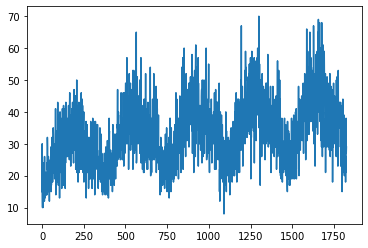

In [6]:
plt.plot(data['21'])

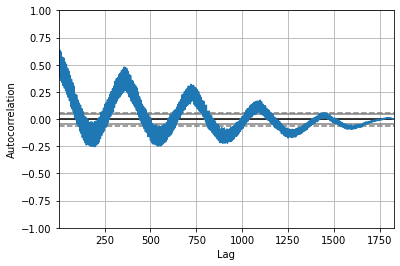

In [ ]:
pd.plotting.autocorrelation_plot(data['21'])

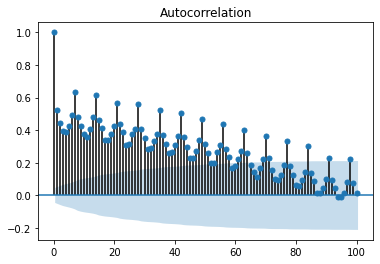

In [10]:
plot_acf(data['21'], lags = 100)
plt.show()

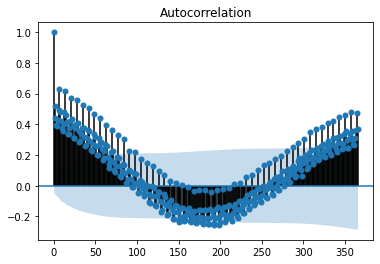

In [ ]:
plot_acf(data['21'] , lags = '365')
plt.show()


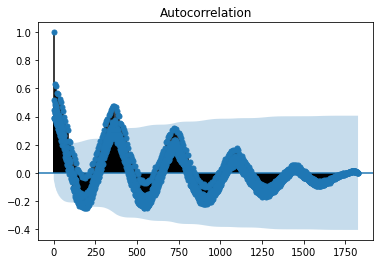

In [ ]:
plot_acf(data['21'] , lags = '1825')
plt.show()

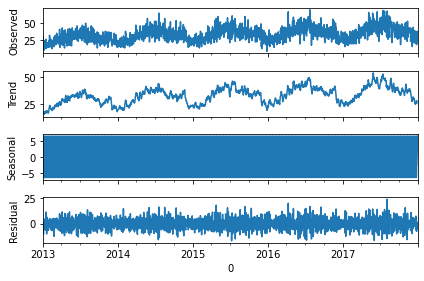

In [15]:
#### Decomposing the time series into trend, seasonality and residual components

x = data[['0','21']]
x = x.set_index('0')
x.asfreq('D')
result = seasonal_decompose(x , model='additive')
result.plot()
plt.show()

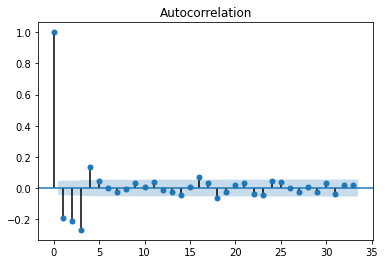

In [199]:
### ACF for residual
residual = result.resid
plot_acf(residual[3:1820])
plt.show() ## lag 3 seems significant

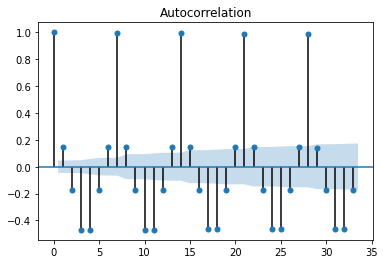

In [ ]:
### ACF for seasonal component
residual = result.resid
plot_acf(result.seasonal[3:1820])
plt.show()

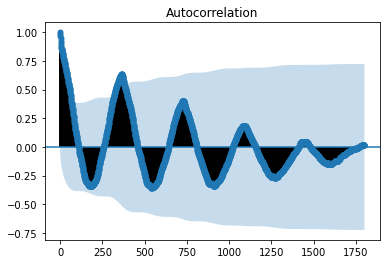

In [ ]:
### ACF for trend
residual = result.resid
plot_acf(result.trend[3:1820],lags = 1800)
plt.show()

/usr/local/lib/python3.7/dist-packages/pwlf/pwlf.py:1109: RuntimeWarning: invalid value encountered in double_scalars
  (self.fit_breaks[i+1]-self.fit_breaks[i])


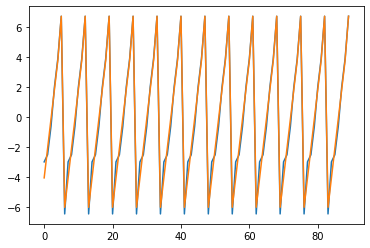

In [23]:
#### Modeling the Seasonality
trend = result.trend
season = result.seasonal
trend.dropna(inplace = True)
season.dropna(inplace = True)

my_time = mdates.date2num(season.index)[0:7]
my_season = season.values.reshape(season.shape[0],)[0:7]

find_season = pwlf.PiecewiseLinFit(my_time%7, my_season)
find_season.fit(2)

my_time = mdates.date2num(season.index)[0:90]
my_season = season.values.reshape(season.shape[0],)[0:90]

plt.plot(list(range(len(my_time))), my_season)
plt.plot(list(range(len(my_time))), find_season.predict(my_time%7))

plt.show()

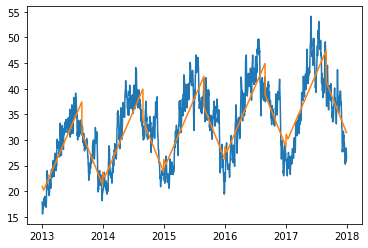

In [210]:
### Modeling the Trend
my_time = mdates.date2num(trend.index)[0:365]
my_trend = trend.values.reshape(trend.shape[0],)[0:365]

find_trend = pwlf.PiecewiseLinFit(my_time%365, my_trend)
find_trend.fit(2)

my_time = mdates.date2num(trend.index)
my_trend = trend.values.reshape(trend.shape[0],)
plt.plot(mdates.num2date(my_time), my_trend)
pred = find_trend.predict(my_time%365) + 2.5*(trend.index.year.values-2013)
plt.plot(mdates.num2date(my_time), pred)

plt.show()


In [24]:
### Pre-processing the Data to be fed into the model
model_data = pd.DataFrame()
trends = pd.DataFrame()
seasons = pd.DataFrame()

for i in range(50):
  x = data[['0',str(i+1)]]
  x = x.set_index('0')
  result = seasonal_decompose(x , model='additive')
  res = result.observed
  model_data = pd.concat([model_data,res] , axis = 1)
  trend = result.trend
  trends = pd.concat([trends,trend] , axis = 1)
  season = result.seasonal
  seasons = pd.concat([seasons,season] , axis = 1)


model_data.dropna(inplace = True)
lagged_data = pd.DataFrame()
lag = 50
for i in range(lag+1):
  lagged_data = pd.concat([model_data.shift(i),lagged_data] , axis = 1 )

lagged_data.columns = list(range(1,50*lag+51))
lagged_data.dropna(inplace = True)
X = lagged_data[list(range(1,lag*50+1))]
Y = lagged_data[list(range(lag*50+1,50*lag+51))]


In [409]:
### Applying SVR using GridSearchCV for selecting hyperparameters and predicting the next values of all the 50 series for train and test set


y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()
params = [{'kernel': ['rbf',], 'gamma': [1,0.1,0.001,0.0001], 'C': [1, 10, 20,50,100]}]

for i in range(50):
   
    
    lim = int(X.shape[0]*0.8)
    trainXdf = X[0:lim]
    testXdf = X[lim:]

    trainYdf = Y[0:lim]
    testYdf = Y[lim:]

    trainXdf = trainXdf.join(trends[str(i+1)])
    trainXdf.columns = list(range(1,50*lag+2))
    trainXdf = trainXdf.join(seasons[str(i+1)])
    trainXdf.columns = list(range(1,50*lag+3))

    testXdf = testXdf.join(trends[str(i+1)])
    testXdf.columns = list(range(1,50*lag+2))
    testXdf = testXdf.join(seasons[str(i+1)])
    testXdf.columns = list(range(1,50*lag+3))

    trainX = trainXdf.to_numpy()
    trainY = trainYdf.to_numpy()
    testX = testXdf.to_numpy()
    testY = testYdf.to_numpy()

    mean = trainX.mean(axis=0).reshape((1, -1))
    std = trainX.std(axis=0).reshape((1, -1))

    trainX = (trainX - mean) / std
    testX = (testX - mean) / std

    gs = GridSearchCV(SVR(), params ,n_jobs=-1 )
    gs.fit(trainX, trainY[:,i])

    svr = gs.best_estimator_

    svr.fit(trainX, trainY[:,i])
    pred = pd.DataFrame(svr.predict(testX))
    y_pred_test = pd.concat([y_pred_test,pred], axis=1)
    pred = pd.DataFrame(svr.predict(trainX))
    y_pred_train = pd.concat([y_pred_train,pred], axis=1)
    print(i+1,"th product best params:", gs.best_params_ )
    print(i+1,"th product best score:", gs.best_score_ )
    print(i+1,"th product train score:",svr.score(trainX , trainY[:,i]) ," test score:" ,svr.score(testX , testY[:,i])) 


1 th product best params: {'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
1 th product best score: 0.10209818988151886
1 th product train score: 0.2842085030285232  test score: 0.11695753632958261
2 th product best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
2 th product best score: 0.10797026725839928
2 th product train score: 0.37241988213035926  test score: 0.1372655135815838
3 th product best params: {'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
3 th product best score: 0.10006636129230864
3 th product train score: 0.2791222743913926  test score: 0.11005693781881898
4 th product best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
4 th product best score: 0.12172617363180374
4 th product train score: 0.3900279815586385  test score: 0.12157933342602943
5 th product best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
5 th product best score: 0.11541057347534452
5 th product train score: 0.4134214285828422  test score: 0.14099532758843747
6 th product best params: {'C': 50, 'g

In [415]:
#### Evaluating MAE for train and test
mae_test = 0 
mae_train = 0
for i in range(50):
  mae_test = mae_test+ mean_absolute_error(testY[:, i], y_pred_test.iloc[:,i])
  mae_train = mae_train+ mean_absolute_error(trainY[:, i], y_pred_train.iloc[:,i])
print("Test MAE:",mae_test/50," , Train MAE",mae_train/50 )

Test MAE: 4.087517147877238  , Train MAE 3.043623572448663


# Experimentation code for individual time series 

In [25]:
y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()


for i in range(21,22):
   
    
    lim = int(X.shape[0]*0.8)
    trainXdf = X[0:lim]
    testXdf = X[lim:]

    trainYdf = Y[0:lim]
    testYdf = Y[lim:]


    trainX = trainXdf.to_numpy()
    trainY = trainYdf.to_numpy()
    testX = testXdf.to_numpy()
    testY = testYdf.to_numpy()

    mean = trainX.mean(axis=0).reshape((1, -1))
    std = trainX.std(axis=0).reshape((1, -1))

    trainX = (trainX - mean) / std
    testX = (testX - mean) / std

    svr = SVR(epsilon = 0.2 , kernel = "rbf" , C= 25)
    svr.fit(trainX, trainY[:,i])
    pred = pd.DataFrame(svr.predict(testX))
    y_pred_test = pd.concat([y_pred_test,pred], axis=1)
    pred = pd.DataFrame(svr.predict(trainX))
    y_pred_train = pd.concat([y_pred_train,pred], axis=1)
    print(i+1,"th product train score:",svr.score(trainX , trainY[:,i]) ," test score:" ,svr.score(testX , testY[:,i])) 


22 th product train score: 0.9946734219993472  test score: 0.6495234133896705


(0.0, 90.0)

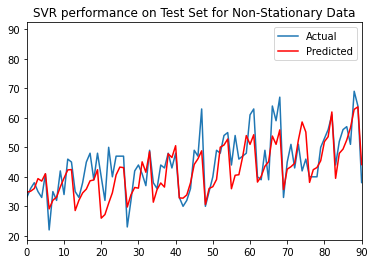

In [28]:
import numpy as np
plt.figure()
plt.title("SVR performance on Test Set for Non-Stationary Data")
plt.plot(np.array(testY)[:, 21] , label = "Actual") 
plt.plot(np.array(y_pred_test) , color ='red',label="Predicted")
plt.legend()
plt.xlim([0,90])

(0.0, 90.0)

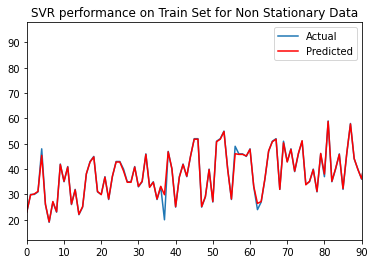

In [31]:
import numpy as np
plt.figure()
plt.title("SVR performance on Train Set for Non Stationary Data")
plt.plot(np.array(trainY)[:, 21] , label = "Actual") 
plt.plot(np.array(y_pred_train) , color ='red' , label="Predicted")
plt.legend()
plt.xlim([0,90])

In [30]:
mae = mean_absolute_error(testY[:, 21], y_pred_test)
print("Test MAE:",mae)

mae = mean_absolute_error(trainY[:, 21], y_pred_train)
print("Train MAE:",mae)

Test MAE: 5.839692865616117
Train MAE: 0.355948726557088


In [375]:
true = pd.DataFrame(testYdf.iloc[:,21])
t = pd.DataFrame(trends.iloc[:,21])
s =pd.DataFrame(seasons.iloc[:,21])
true = true.join(t)
true.columns = list(range(2))
true = true.join(s)
true.columns = list(["Resid","Trend" ,"Seasonal"])
true

,Resid,Trend,Seasonal
0,,,
2016-12-30,6.888462,38.857143,3.254396
2016-12-31,11.993956,38.571429,6.434615
2017-01-01,-5.033516,39.285714,8.747802
2017-01-02,-4.600000,39.571429,-9.971429
2017-01-03,-6.045604,37.285714,-4.240110
...,...,...,...
2017-12-24,-8.604945,41.857143,8.747802
2017-12-25,-3.171429,40.142857,-9.971429
2017-12-26,12.954396,39.285714,-4.240110


In [381]:
predicted = y_pred_test.iloc[:,0].values + true.iloc[:,1].values + true.iloc[:,2].values
actual = true.iloc[:,0]+true.iloc[:,1]+true.iloc[:,2]

In [ ]:
for i in range(364):
  print("Predicted",predicted[i] , "Actual:" ,actual[i])

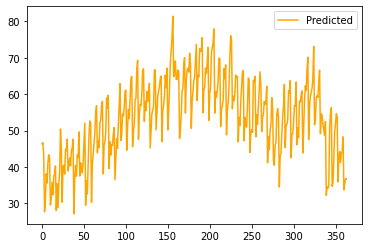

In [444]:
plt.plot(predicted , label = "Predicted",color ="orange" , )
plt.legend()

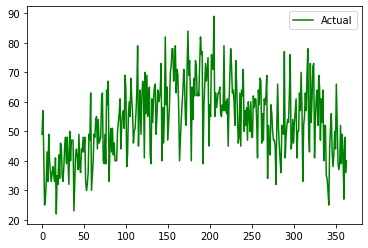

In [400]:
plt.figure()
plt.plot(actual.values, label = "Actual" ,color = "green")
plt.legend()
plt.show()

In [383]:
mean_absolute_error(predicted, actual)

4.58901562243137